# ParFlow Short Course: Overland Flow
## Exercise: Runoff generation mechanisms

### Problem Description
The objective here is to demonstrate the different runoff mechanisms using a fairly simple, but not too simple, geometry by the process of excess infiltration (i.e. when the rain rate exceeds the saturated hydraulic conductivity of the surface). 

In [4]:
#  This script can be configured to run either a Hortonian or Dunne flow example
# using ParFlow. It is configured to run using the orthogonal grid
# using a PFSOLID file and to output total runoff.

# R. Maxwell, originally developed in 2009, updated PF Short Course 2019, updated to Python and Jupyter 2022
# reedmaxwell@princeton.edu

from parflow import Run
from parflow.tools.fs import get_absolute_path, cp, rm, mkdir, exists
import numpy as np

# set up directories
base_dir = get_absolute_path(".")
Dunne = Run("Dunne")
mkdir('dunne_over')

Dunne.FileVersion = 4

Dunne.Process.Topology.P = 1
Dunne.Process.Topology.Q = 1
Dunne.Process.Topology.R = 1

#---------------------------------------------------------
# Computational Grid
#---------------------------------------------------------
Dunne.ComputationalGrid.Lower.X = 0.0
Dunne.ComputationalGrid.Lower.Y = 0.0
Dunne.ComputationalGrid.Lower.Z = 0.0

Dunne.ComputationalGrid.NX = 20
Dunne.ComputationalGrid.NY = 1
Dunne.ComputationalGrid.NZ = 300

Dunne.ComputationalGrid.DX = 5.0
Dunne.ComputationalGrid.DY = 1.0
Dunne.ComputationalGrid.DZ = .05

#---------------------------------------------------------
# Domain Geometry
#---------------------------------------------------------
Dunne.GeomInput.Names = 'solidinput1'

Dunne.GeomInput.solidinput1.InputType = 'SolidFile'
Dunne.GeomInput.solidinput1.GeomNames = 'domain'
Dunne.GeomInput.solidinput1.FileName = '../domain.pfsol'

Dunne.Geom.domain.Patches = 'z_upper x_lower y_lower x_upper y_upper z_lower'

#-----------------------------------------------------------------------------
# Perm
#-----------------------------------------------------------------------------

Dunne.Geom.Perm.Names = 'domain'

# Values in m/hour

Dunne.Geom.domain.Perm.Type = 'Constant'
Dunne.Geom.domain.Perm.Value = 1.
Dunne.Geom.domain.Perm.Value = 0.001

Dunne.Perm.TensorType = 'TensorByGeom'

Dunne.Geom.Perm.TensorByGeom.Names = 'domain'

Dunne.Geom.domain.Perm.TensorValX = 1.0
Dunne.Geom.domain.Perm.TensorValY = 1.0
Dunne.Geom.domain.Perm.TensorValZ = 1.0

#-----------------------------------------------------------------------------
# Specific Storage
#-----------------------------------------------------------------------------

Dunne.SpecificStorage.Type = 'Constant'
Dunne.SpecificStorage.GeomNames = 'domain'
Dunne.Geom.domain.SpecificStorage.Value = 1.0e-5

#-----------------------------------------------------------------------------
# Phases
#-----------------------------------------------------------------------------

Dunne.Phase.Names = 'water'

Dunne.Phase.water.Density.Type = 'Constant'
Dunne.Phase.water.Density.Value = 1.0

Dunne.Phase.water.Viscosity.Type = 'Constant'
Dunne.Phase.water.Viscosity.Value = 1.0

#-----------------------------------------------------------------------------
# Contaminants
#-----------------------------------------------------------------------------

Dunne.Contaminants.Names = ''

#-----------------------------------------------------------------------------
# Retardation
#-----------------------------------------------------------------------------

Dunne.Geom.Retardation.GeomNames = ''

#-----------------------------------------------------------------------------
# Gravity
#-----------------------------------------------------------------------------

Dunne.Gravity = 1.0

#-----------------------------------------------------------------------------
# Setup timing info
#-----------------------------------------------------------------------------

# run for 3 hours @ 3min timesteps
#
Dunne.TimingInfo.BaseUnit = 0.01
Dunne.TimingInfo.StartCount = 0
Dunne.TimingInfo.StartTime = 0.0
Dunne.TimingInfo.StopTime = 1.0
Dunne.TimingInfo.DumpInterval = -1
Dunne.TimeStep.Type = 'Constant'
Dunne.TimeStep.Value = 0.01

#-----------------------------------------------------------------------------
# Porosity
#-----------------------------------------------------------------------------

Dunne.Geom.Porosity.GeomNames = 'domain'
Dunne.Geom.domain.Porosity.Type = 'Constant'
Dunne.Geom.domain.Porosity.Value = 0.01

#-----------------------------------------------------------------------------
# Domain
#-----------------------------------------------------------------------------

Dunne.Domain.GeomName = 'domain'

#-----------------------------------------------------------------------------
# Relative Permeability
#-----------------------------------------------------------------------------

Dunne.Phase.RelPerm.Type = 'VanGenuchten'
Dunne.Phase.RelPerm.GeomNames = 'domain'

Dunne.Geom.domain.RelPerm.Alpha = 1.0
Dunne.Geom.domain.RelPerm.N = 2.

#---------------------------------------------------------
# Saturation
#---------------------------------------------------------

Dunne.Phase.Saturation.Type = 'VanGenuchten'
Dunne.Phase.Saturation.GeomNames = 'domain'

Dunne.Geom.domain.Saturation.Alpha = 1.0
Dunne.Geom.domain.Saturation.N = 2.
Dunne.Geom.domain.Saturation.SRes = 0.2
Dunne.Geom.domain.Saturation.SSat = 1.0

#-----------------------------------------------------------------------------
# Wells
#-----------------------------------------------------------------------------
Dunne.Wells.Names = ''

#-----------------------------------------------------------------------------
# Time Cycles
#-----------------------------------------------------------------------------
Dunne.Cycle.Names = 'constant rainrec'
Dunne.Cycle.constant.Names = 'alltime'
Dunne.Cycle.constant.alltime.Length = 1
Dunne.Cycle.constant.Repeat = -1

# rainfall and recession time periods are defined here
# rain for 3 hours, recession for 2 hours (change to rain for a different time)
# this is a function of the BaseUnit set above, that is each length
# is an integer mulitplier of that value.  The BaseUnit happens to be equal
# to our timestep but that need not be the case, it's just good practice

Dunne.Cycle.rainrec.Names = 'rain rec'
Dunne.Cycle.rainrec.rain.Length = 30
Dunne.Cycle.rainrec.rec.Length = 70
Dunne.Cycle.rainrec.Repeat = -1


#-----------------------------------------------------------------------------
# Boundary Conditions: Pressure
#-----------------------------------------------------------------------------
# specify patches as a list for BC's
Dunne.BCPressure.PatchNames = 'z_upper x_lower y_lower x_upper y_upper z_lower'

Dunne.Patch.x_lower.BCPressure.Type = 'FluxConst'
Dunne.Patch.x_lower.BCPressure.Cycle = 'constant'
Dunne.Patch.x_lower.BCPressure.alltime.Value = 0.0

Dunne.Patch.y_lower.BCPressure.Type = 'FluxConst'
Dunne.Patch.y_lower.BCPressure.Cycle = 'constant'
Dunne.Patch.y_lower.BCPressure.alltime.Value = 0.0

Dunne.Patch.z_lower.BCPressure.Type = 'FluxConst'
Dunne.Patch.z_lower.BCPressure.Cycle = 'constant'
Dunne.Patch.z_lower.BCPressure.alltime.Value = 0.0

Dunne.Patch.x_upper.BCPressure.Type = 'FluxConst'
Dunne.Patch.x_upper.BCPressure.Cycle = 'constant'
Dunne.Patch.x_upper.BCPressure.alltime.Value = 0.0

Dunne.Patch.y_upper.BCPressure.Type = 'FluxConst'
Dunne.Patch.y_upper.BCPressure.Cycle = 'constant'
Dunne.Patch.y_upper.BCPressure.alltime.Value = 0.0

## overland flow boundary condition with very heavy rainfall then recession
Dunne.Patch.z_upper.BCPressure.Type = 'OverlandFlow'
Dunne.Patch.z_upper.BCPressure.Cycle = 'rainrec'
Dunne.Patch.z_upper.BCPressure.rain.Value = -0.02
Dunne.Patch.z_upper.BCPressure.rec.Value = 0.00

#---------------------------------------------------------
# Topo slopes in x-direction
#---------------------------------------------------------

Dunne.TopoSlopesX.Type = 'Constant'
Dunne.TopoSlopesX.GeomNames = 'domain'
Dunne.TopoSlopesX.Geom.domain.Value = 0.05

#---------------------------------------------------------
# Topo slopes in y-direction
#---------------------------------------------------------


Dunne.TopoSlopesY.Type = 'Constant'
Dunne.TopoSlopesY.GeomNames = 'domain'
Dunne.TopoSlopesY.Geom.domain.Value = 0.00

#---------------------------------------------------------
# Mannings coefficient
#---------------------------------------------------------

Dunne.Mannings.Type = 'Constant'
Dunne.Mannings.GeomNames = 'domain'
Dunne.Mannings.Geom.domain.Value = 1.e-5

#-----------------------------------------------------------------------------
# Phase sources:
#-----------------------------------------------------------------------------

Dunne.PhaseSources.water.Type = 'Constant'
Dunne.PhaseSources.water.GeomNames = 'domain'
Dunne.PhaseSources.water.Geom.domain.Value = 0.0

#-----------------------------------------------------------------------------
# Exact solution specification for error calculations
#-----------------------------------------------------------------------------

Dunne.KnownSolution = 'NoKnownSolution'


#-----------------------------------------------------------------------------
# Set solver parameters
#-----------------------------------------------------------------------------

Dunne.Solver = 'Richards'
Dunne.Solver.MaxIter = 2500

Dunne.Solver.Nonlinear.MaxIter = 300
Dunne.Solver.Nonlinear.ResidualTol = 1e-6
Dunne.Solver.Nonlinear.EtaChoice = 'Walker1'
Dunne.Solver.Nonlinear.EtaValue = 0.001
Dunne.Solver.Nonlinear.UseJacobian = False
#Dunne.Solver.Nonlinear.UseJacobian = True
Dunne.Solver.Nonlinear.DerivativeEpsilon = 1e-16
Dunne.Solver.Nonlinear.StepTol = 1e-20
Dunne.Solver.Nonlinear.Globalization = 'LineSearch'
Dunne.Solver.Linear.KrylovDimension = 20
Dunne.Solver.Linear.MaxRestart = 2

#Dunne.Solver.Linear.Preconditioner.PCMatrixType = 'FullJacobian'

Dunne.Solver.Linear.Preconditioner = 'MGSemi'
Dunne.Solver.PrintSubsurf = False
Dunne.Solver.Drop = 1E-20
Dunne.Solver.AbsTol = 1E-12

Dunne.Solver.PrintOverlandSum = True

# write out a lot of output as SILO Files
Dunne.Solver.WriteSiloSubsurfData = False
Dunne.Solver.WriteSiloPressure = False
Dunne.Solver.WriteSiloSaturation = False
Dunne.Solver.WriteSiloSlopes = False
Dunne.Solver.WriteSiloMask = False
Dunne.Solver.WriteSiloEvapTrans = False
Dunne.Solver.WriteSiloEvapTransSum = False
Dunne.Solver.WriteSiloOverlandSum = False
Dunne.Solver.WriteSiloMannings = False
Dunne.Solver.WriteSiloSpecificStorage = False

#---------------------------------------------------------
# Initial conditions: water pressure
#---------------------------------------------------------

# set water table to be level with the outlet of the domain
Dunne.ICPressure.Type = 'HydroStaticPatch'
Dunne.ICPressure.GeomNames = 'domain'
Dunne.Geom.domain.ICPressure.Value = 4.5
Dunne.Geom.domain.ICPressure.Value = 0.5

Dunne.Geom.domain.ICPressure.RefGeom = 'domain'
Dunne.Geom.domain.ICPressure.RefPatch = 'z_lower'

#--------
# Things that can be changed in the simulation to swap from Horton to Dunne flow
#--------

# increase the hydraulic conductivity
# if the K values are in m/h and the rainfall rate is 0.02 m/h what K is needed
# to create infiltration not overland flow? 
#Dunne.Geom.domain.Perm.Value = ?

# move the water table closer to the outlet, i.e. make it shallower
# if the initial pressure value is in meters from the bottom of the domain
# what value will create water table interactions?
#Dunne.Geom.domain.ICPressure.Value = ?

#-----------------------------------------------------------------------------
# Run and Unload the ParFlow output files
#-----------------------------------------------------------------------------

# create a subdirectory to run in, change to this directory
Dunne.run(base_dir+'/dunne_over')




# ==============================================================================
# ParFlow directory
#  - /Users/reed/parflow/parflow-12-april-24
# ParFlow version
#  - 3.12.0
# Working directory
#  - /Users/reed/Projects/HydroData/parflow_short_course_updated/5_overland_flow/dunne_over
# ParFlow database
#  - Dunne.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================



In [5]:
import parflow as pf

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from parflow.tools.fs import get_absolute_path, cp, rm, mkdir, exists


N=101
time    = np.arange(N)    # time array, we will probably want to swap with a date (not applicaple to JMH)
base_dir = get_absolute_path(".")

files = glob(base_dir+"/dunne_over/Dunne.out.satur.*.pfb")
sat = pf.read_pfb_sequence(files)
files = glob(base_dir+"/dunne_over/Dunne.out.press.*.pfb")
press = pf.read_pfb_sequence(files)
files = glob(base_dir+"/dunne_over/Dunne.out.overlandsum.*.pfb")
overland_sum = pf.read_pfb_sequence(files)


### Calculate total flow from the domain
ParFlow does not directly output streamflow for us, so to get overland flow we use Manning's equation applied to the pressures in whatever cell we want to compute the flow. To do so we can use the following: 

$Q [L^3/T] = \dfrac{\sqrt{S_0}}{n} \times h^{5/3} \times \Delta y$

where $S_0$ is the bedslope (can be different in _each_ direction), $h$ is the pressure head (ponded water depth), $n$ is the Manning roughness coefficient, and $\Delta y$ is the cell width in the direction orthogonal to the slope, recall that here $\Delta y=1$. Note that the spatial and temporal units are linked through the Manning coefficient and that ParFlow makes no assumptions about the units. If you like, you can write this is the area*velocity form, where the cross-sectional area is $h \times \Delta y$, in which case the exponent on $h$ changes to $h^{2/3}$. 

If you want to integrate this to get a volume, rather than a flux, multiply by the time step, $\Delta t$. 

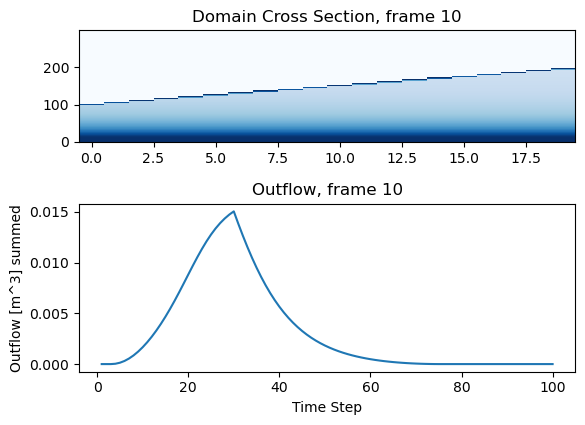

In [7]:
# slope and Manning's n
mannings = 1.e-5
slope = 0.05

# calculate outflow first by reading from ParFlow
outflow = overland_sum[:,0,0,0]  
##  next using manning's eq 
## total flow out of the domain is

outflow_m= (np.sqrt(slope)/mannings) * np.maximum(press[:,102,0,0],0.0)**(5.0/3.0)*0.01*1.0


# set a variable for the timestep plotted in saturation cross section
icount = 10

## Plot results
## three subplots
fig, ax = plt.subplots(2)

ax[0].cla()
ax[0].imshow(sat[icount,:,0,:],vmin=0.1, vmax=1.0,origin='lower',aspect=0.015,cmap='Blues',interpolation='none')  #,extent=[0,100,0,1])
ax[0].set_title("Domain Cross Section, frame {}".format(icount))

ax[1].cla()
ax[1].plot(time[1:],outflow)
#ax[1].plot(time,outflow_m[1:102])
ax[1].set_title("Outflow, frame {}".format(icount))
ax[1].set_xlabel("Time Step")
ax[1].set_ylabel("Outflow [m^3]")


plt.show()
